In [1]:
# set cwd to ..
import os
os.chdir("..")
print(os.getcwd())

/Users/sondresorbye/Desktop/Pre-project-transformer


In [15]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define number of samples
num_samples = 1000

# Generate features
credit_scores = np.random.randint(300, 850, num_samples)
incomes = np.random.randint(20000, 150000, num_samples)
loan_amounts = np.random.randint(1000, 50000, num_samples)
loan_income_ratios = loan_amounts / incomes

# Generate labels (0 for non-default, 1 for default)
# For simplicity, let's assume a simple rule: if loan_income_ratio > 0.3, default (1), else non-default (0)
labels = (loan_income_ratios > 0.2).astype(int)
labels = labels * (credit_scores > 850 - 300).astype(int)  # Only default if credit score > 600

# Introduce noise to labels to simulate uncertainty
noise = np.random.binomial(1, 0.2, num_samples)  # 10% noise
noisy_labels = np.abs(labels - noise)  # Flip labels with noise

# Create DataFrame for in-distribution data
data = pd.DataFrame({
    'credit_score': credit_scores,
    'income': incomes,
    'loan_income_ratio': loan_income_ratios,
    'loan_status': noisy_labels
})

# Generate out-of-distribution data
ood_num_samples = 200
ood_credit_scores = np.hstack((np.random.randint(50, 100, ood_num_samples // 2), np.random.randint(1000, 1500, ood_num_samples // 2)))
ood_incomes = np.hstack((np.random.randint(5000, 10000, ood_num_samples // 2), np.random.randint(200000, 400000, ood_num_samples // 2)))
ood_loan_amounts = np.hstack((np.random.randint(80000, 100000, ood_num_samples // 2), np.random.randint(500, 800, ood_num_samples // 2)))
ood_loan_income_ratios = ood_loan_amounts / ood_incomes

# Generate labels for OOD data (randomly for testing purposes)
#ood_labels = np.random.randint(0, 2, ood_num_samples)
ood_labels = np.hstack((np.random.binomial(1, 0.2, ood_num_samples // 2), np.random.binomial(1, 0.8, ood_num_samples // 2)))

# Create DataFrame for OOD data
ood_data = pd.DataFrame({
    'credit_score': ood_credit_scores,
    'income': ood_incomes,
    'loan_income_ratio': ood_loan_income_ratios,
    'loan_status': ood_labels
})

# Save in-distribution and OOD data to CSV
data.to_csv('p2p_lending/data/dummy_p2p_lending_dataset.csv', index=False)
ood_data.to_csv('p2p_lending/data/dummy_p2p_lending_ood_dataset.csv', index=False)

print("In-distribution dataset created and saved to 'dummy_p2p_lending_dataset.csv'")
print("Out-of-distribution dataset created and saved to 'dummy_p2p_lending_ood_dataset.csv'")



In-distribution dataset created and saved to 'dummy_p2p_lending_dataset.csv'
Out-of-distribution dataset created and saved to 'dummy_p2p_lending_ood_dataset.csv'


Epoch [10/50], Loss: 0.1698
Epoch [20/50], Loss: 0.1341
Epoch [30/50], Loss: 0.2133
Epoch [40/50], Loss: 0.1740
Epoch [50/50], Loss: 0.1614
In-distribution AUC: 0.7747
OOD AUC: 0.2164
y_pred mean 0.37094033
y_pred_ood mean 0.7033806
Average epistemic uncertainty (in-distribution): 0.011454578
Average epistemic uncertainty (OOD): 0.7277546
Epistemic error correlation (in-distribution): 0.0329
Epistemic error correlation (OOD): 0.6076


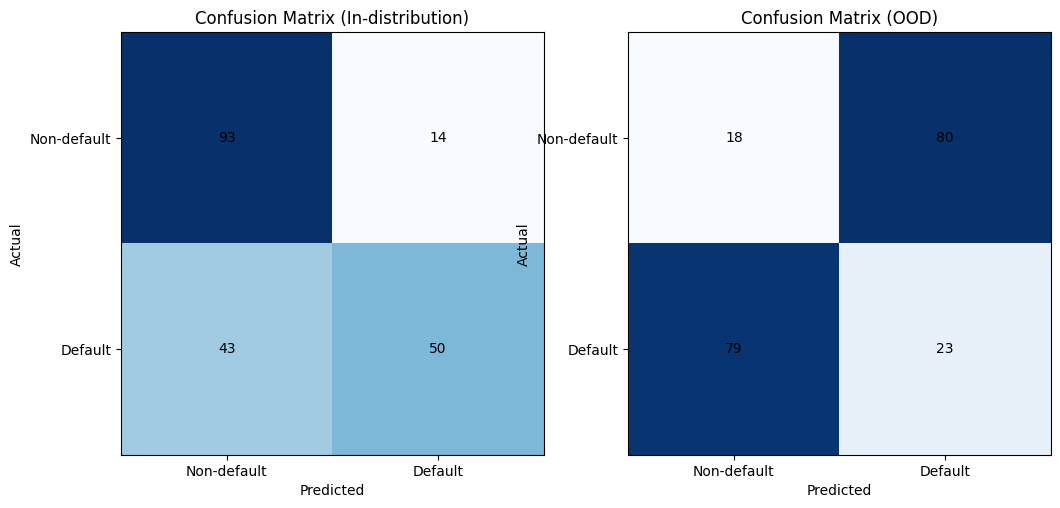

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from p2p_lending.utils.dataset import (
    create_dataset_with_embeddings,
    normalize,
    oversample_minority_class,
    split_data,
)

from p2p_lending.models.deep_feed_forward_model import DeepFeedForwardModel

# Load datasets
data = pd.read_csv("p2p_lending/data/dummy_p2p_lending_dataset.csv")
ood_data = pd.read_csv("p2p_lending/data/dummy_p2p_lending_ood_dataset.csv")

data, ood_data, _, scaler = normalize(
    data, ood_data, ood_data, ["credit_score", "income", "loan_income_ratio"]
)

# Preprocess data
X = data[["credit_score", "income", "loan_income_ratio"]].values
y = data["loan_status"].values
X_ood = ood_data[["credit_score", "income", "loan_income_ratio"]].values
y_ood = ood_data["loan_status"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
X_ood = torch.tensor(X_ood, dtype=torch.float32)
y_ood = torch.tensor(y_ood, dtype=torch.float32).unsqueeze(1)


# Define neural network model with MC Dropout
class MCDropoutModel(nn.Module):
    def __init__(self):
        super(MCDropoutModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        #x = torch.sigmoid(x)
        return x


model = MCDropoutModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
batch_size = 32
train_loader = DataLoader(
    TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

model.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


# Function to get MC Dropout predictions
def mc_dropout_predictions(model, X, n_samples=100):
    model.train()  # Ensure dropout is enabled
    predictions = np.array([model(X).detach().numpy() for _ in range(n_samples)])
    return predictions


# Evaluate model on in-distribution data
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy().flatten()
auc = roc_auc_score(y_test.numpy(), y_pred)
print(f"In-distribution AUC: {auc:.4f}")

# Evaluate model on OOD data
with torch.no_grad():
    y_pred_ood = model(X_ood).numpy().flatten()
auc_ood = roc_auc_score(y_ood.numpy(), y_pred_ood)
print(f"OOD AUC: {auc_ood:.4f}")

# Calculate uncertainty using MC Dropout
n_samples = 100
mc_preds = mc_dropout_predictions(model, X_test, n_samples)
mc_preds_ood = mc_dropout_predictions(model, X_ood, n_samples)

# Calculate epistemic uncertainty (variance of predictions)
epistemic_uncertainty = np.var(mc_preds, axis=0)
epistemic_uncertainty_ood = np.var(mc_preds_ood, axis=0)

# Convert pred to binary
# y_pred = (y_pred > 0.5).astype(int)
# y_pred_ood = (y_pred_ood > 0.5).astype(int)

# Calculate error
print("y_pred mean", y_pred.mean())
print("y_pred_ood mean", y_pred_ood.mean())


errors = np.abs(y_test.squeeze().numpy() - y_pred)
errors_ood = np.abs(y_ood.squeeze().numpy() - y_pred_ood)

epistemic_uncertainty = epistemic_uncertainty.ravel()
epistemic_uncertainty_ood = epistemic_uncertainty_ood.ravel()

print(
    "Average epistemic uncertainty (in-distribution):", np.mean(epistemic_uncertainty)
)
print("Average epistemic uncertainty (OOD):", np.mean(epistemic_uncertainty_ood))

# Calculate correlation between uncertainty and error
epistemic_error_correlation = np.corrcoef(epistemic_uncertainty, errors)[0, 1]
epistemic_error_correlation_ood = np.corrcoef(epistemic_uncertainty_ood, errors_ood)[
    0, 1
]

print(
    f"Epistemic error correlation (in-distribution): {epistemic_error_correlation:.4f}"
)
print(f"Epistemic error correlation (OOD): {epistemic_error_correlation_ood:.4f}")

# Confusion matrix
y_pred = (y_pred > 0.5).astype(int)
y_pred_ood = (y_pred_ood > 0.5).astype(int)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
cm_ood = confusion_matrix(y_ood, y_pred_ood)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cm, cmap="Blues", interpolation="nearest")
ax[0].set_title("Confusion Matrix (In-distribution)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")
ax[0].set_xticks([0, 1])
ax[0].set_yticks([0, 1])
ax[0].set_xticklabels(["Non-default", "Default"])
ax[0].set_yticklabels(["Non-default", "Default"])
for i in range(2):
    for j in range(2):
        ax[0].text(j, i, cm[i, j], ha="center", va="center", color="black")
ax[1].imshow(cm_ood, cmap="Blues", interpolation="nearest")
ax[1].set_title("Confusion Matrix (OOD)")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")
ax[1].set_xticks([0, 1])
ax[1].set_yticks([0, 1])
ax[1].set_xticklabels(["Non-default", "Default"])
ax[1].set_yticklabels(["Non-default", "Default"])
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, cm_ood[i, j], ha="center", va="center", color="black")

# Results

## Without sigmoid

Epoch [10/50], Loss: 0.1698
Epoch [20/50], Loss: 0.1341
Epoch [30/50], Loss: 0.2133
Epoch [40/50], Loss: 0.1740
Epoch [50/50], Loss: 0.1614
In-distribution AUC: 0.7747
OOD AUC: 0.2164
y_pred mean 0.37094033
y_pred_ood mean 0.7033806
Average epistemic uncertainty (in-distribution): 0.011454578
Average epistemic uncertainty (OOD): 0.7277546
Epistemic error correlation (in-distribution): 0.0329
Epistemic error correlation (OOD): 0.6076

## With sigmoid

In-distribution AUC: 0.7818
OOD AUC: 0.2114
y_pred mean 0.4466389
y_pred_ood mean 0.5850634
Average epistemic uncertainty (in-distribution): 0.007113463
Average epistemic uncertainty (OOD): 0.12605795
Epistemic error correlation (in-distribution): 0.0142
Epistemic error correlation (OOD): 0.0304

In [27]:
from matplotlib import pyplot as plt
from ipywidgets import interact

def plot_predictions(credit_score, income, loan_income_ratio):
    input_value = np.array([[credit_score, income, loan_income_ratio]])
    input_value = scaler.transform(input_value)
    input_value = torch.tensor(input_value, dtype=torch.float32)
    mc_predictions = mc_dropout_predictions(model, input_value, n_samples=1000)
    mean, std = np.mean(mc_predictions), np.std(mc_predictions)
    print(f"Mean prediction: {mean:.4f}, Std prediction: {std:.4f}")

# Create an interactive slider
interact(plot_predictions, credit_score=(50, 1250), income=(7500, 300000), loan_income_ratio=(650/300000, 90000/7500, 0.01))

interactive(children=(IntSlider(value=650, description='credit_score', max=1250, min=50), IntSlider(value=1537…

<function __main__.plot_predictions(credit_score, income, loan_income_ratio)>